In [1]:
# Import necessary packages

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as pltimg

In [3]:
print(tf.__version__)

2.8.0


In [4]:
print(len(tf.config.list_physical_devices('GPU')) > 0)

True


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
datasets_list = tfds.list_builders()
datasets_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adroit_hammer',
 'd4rl_adroit_pen',
 'd4rl_adroit_relocate',
 'd4rl_mujoco_ant',
 'd4

In [7]:
(training_data, testing_data), ds_info = tfds.load(name="mnist",
                                             as_supervised=True,
                                             with_info=True,
                                             shuffle_files=False,
                                             split=["train", "test"])

In [8]:
len(training_data), len(testing_data)

(60000, 10000)

In [9]:
sample_train_data = training_data.take(1)
sample_train_data

<TakeDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
len(sample_train_data)

1

In [11]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [12]:
class_names = ds_info.features["label"].names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [13]:
for image, label in sample_train_data:
    print(f"Image shape: {image.shape}\nImage datatype: {image.dtype}\nTarget class: {label}\nClass name: {class_names[label.numpy()]}")

Image shape: (28, 28, 1)
Image datatype: <dtype: 'uint8'>
Target class: 4
Class name: 4


(-0.5, 27.5, 27.5, -0.5)

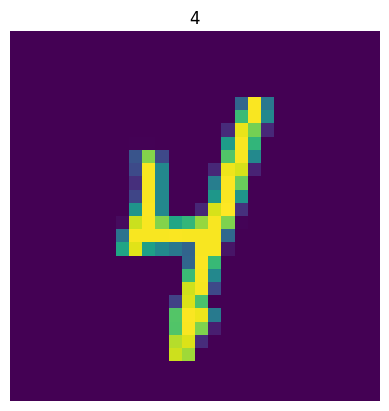

In [14]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [15]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [16]:
# Preprocess the image
def preprocess_image(image, label):
    img = tf.cast(image, dtype=tf.float32)
    img = img/255.
    return img, label

In [17]:
image, label = preprocess_image(image, label)
print(image.dtype)

<dtype: 'float32'>


In [18]:
# Splitting into train and valid using train data
val_percent = 0.2
num_train_examples = ds_info.splits["train"].num_examples
num_val_examples = int(val_percent * num_train_examples)
num_train_examples, num_val_examples

(60000, 12000)

In [19]:
train_data = training_data.take(num_train_examples - num_val_examples)
val_data = training_data.skip(num_train_examples - num_val_examples)
len(train_data), len(val_data)

(48000, 12000)

In [20]:
def create_performant_dataset(dataset, func, batch_size, train=True):
    dataset = dataset.map(map_func=func, num_parallel_calls=tf.data.AUTOTUNE)
    if train:
        dataset = dataset.shuffle(buffer_size=1000).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        dataset = dataset.batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [21]:
train_data = create_performant_dataset(dataset=train_data,
                                       func=preprocess_image,
                                       batch_size=64)

val_data = create_performant_dataset(dataset=val_data,
                                     func=preprocess_image,
                                     batch_size=64)

test_data = create_performant_dataset(dataset=testing_data,
                                      func=preprocess_image,
                                      batch_size=64,
                                      train=False)

len(train_data), len(val_data), len(test_data)

(750, 188, 157)

In [22]:
train_data, val_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [23]:
sample_64_images = []
sample_64_labels = []
for i in train_data.take(1).unbatch().as_numpy_iterator():
    img, label = i
    sample_64_images.append(img)
    sample_64_labels.append(label)

In [24]:
len(sample_64_images), len(sample_64_labels)

(64, 64)

In [25]:
sample_64_images[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [26]:
import random
def view_random_sample_images(img, label):
    random_num = random.randint(0, len(img))
    random_img = img[random_num]
    random_label = label[random_num]

    plt.figure(figsize=(10, 7))
    plt.imshow(random_img)
    plt.title(class_names[random_label])
    plt.axis(False)

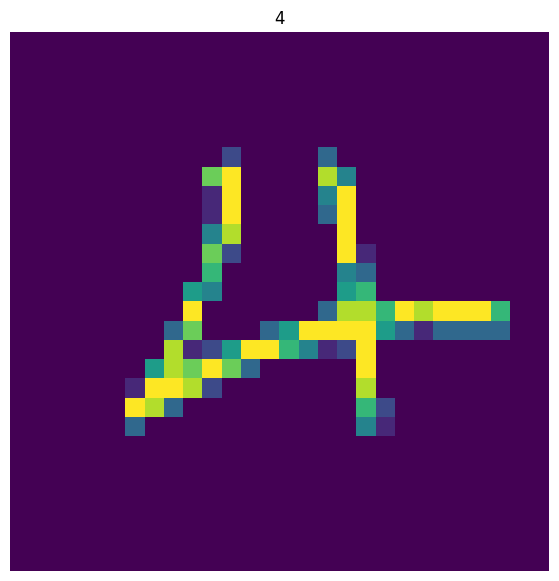

In [27]:
view_random_sample_images(img=sample_64_images,
                          label=sample_64_labels)

In [28]:
# Creating callbacks
import os
import datetime

CHECKPOINT_PATH = "model_experiments_mnist_cnn"
TENSORBOARD_PATH = "model_logs_mnist_cnn"

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10 ** (epoch/2), verbose=1)

def checkpoint_callback(model_name):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_PATH, model_name), 
                                              save_best_only=True, 
                                              monitor="val_loss", 
                                              verbose=1)

def tensorboard_callback(model_name):
    log_dir = TENSORBOARD_PATH + "/" + model_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return tf.keras.callbacks.TensorBoard(log_dir)

In [29]:
INPUT_SHAPE = (28, 28, 1)
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, dtype=tf.float32)
x = tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu")(inputs)
x = tf.keras.layers.Conv2D(10, 3, activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid")(x)
x = tf.keras.layers.Conv2D(10, 3, activation="relu")(x)
x = tf.keras.layers.Conv2D(10, 3, activation="relu")(x)
x = tf.keras.layers.MaxPool2D(2)(x)
x = tf.keras.layers.Flatten()(x)
outputs= tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [30]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 10)        100       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 10)        910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 10)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 10)        910       
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 10)          910       
                                                           

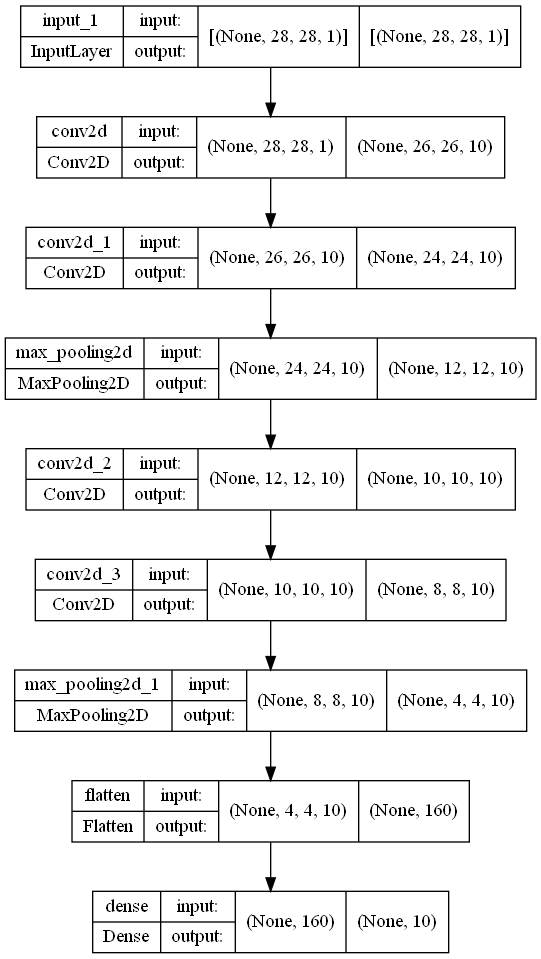

In [31]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

In [32]:
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(train_data,
                              validation_data=val_data,
                              steps_per_epoch=len(train_data),
                              validation_steps=len(val_data),
                              epochs=15,
                              callbacks=[lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/15
750/750 [==============================] - 25s 14ms/step - loss: 2.2844 - accuracy: 0.1671 - val_loss: 2.2625 - val_accuracy: 0.1914 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 3.1622776601683795e-05.
Epoch 2/15
750/750 [==============================] - 9s 12ms/step - loss: 1.9163 - accuracy: 0.3970 - val_loss: 1.2806 - val_accuracy: 0.6286 - lr: 3.1623e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/15
750/750 [==============================] - 8s 11ms/step - loss: 0.6438 - accuracy: 0.8018 - val_loss: 0.4480 - val_accuracy: 0.8592 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00031622776601683794.
Epoch 4/15
750/750 [==============================] - 7s 10ms/step - loss: 0.3328 - accuracy: 0.8974 - val_loss: 0.2693 - val_accuracy: 0.9218 - lr: 3.1623e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoc

<Axes: >

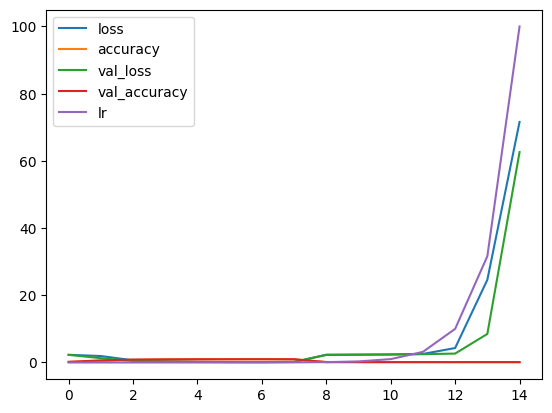

In [33]:
pd.DataFrame(model_1_history.history).plot()

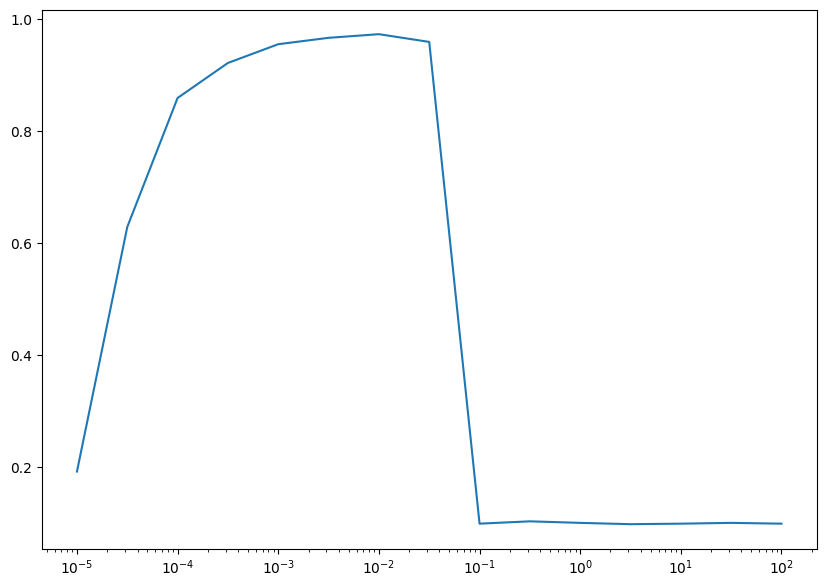

In [34]:
lrs = 1e-5 * 10 ** (tf.range(15)/2)
plt.figure(figsize=(10,7))
plt.semilogx(lrs, model_1_history.history["val_accuracy"])

In [35]:
10**-4

0.0001

In [36]:
from tensorflow.keras import layers
inputs = layers.Input(shape=INPUT_SHAPE, dtype=tf.float32)
x = layers.Conv2D(filters=10, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(10, 3, activation="relu")(x)
x = layers.MaxPool2D(2, padding="valid")(x)
x = layers.Conv2D(10, 3, activation="relu")(x)
x = layers.Conv2D(10, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2")

model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics="accuracy")

C:\Users\yihim\anaconda3\envs\mldl\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 10)        100       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 10)        910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 10)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 10)        910       
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 10)          910       
                                                           

In [38]:
model_2_history = model_2.fit(train_data,
                              validation_data=val_data,
                              steps_per_epoch=len(train_data),
                              validation_steps=len(val_data),
                              epochs=15,
                              callbacks=[tensorboard_callback(model_name=model_2.name),
                                         checkpoint_callback(model_name=model_2.name),
                                         early_stopping])

Epoch 1/15
744/750 [============================>.] - ETA: 0s - loss: 1.4030 - accuracy: 0.5500
Epoch 1: val_loss improved from inf to 0.52144, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 9s 11ms/step - loss: 1.3954 - accuracy: 0.5526 - val_loss: 0.5214 - val_accuracy: 0.8418
Epoch 2/15
744/750 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8783
Epoch 2: val_loss improved from 0.52144 to 0.33503, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 11ms/step - loss: 0.4008 - accuracy: 0.8785 - val_loss: 0.3350 - val_accuracy: 0.8968
Epoch 3/15
744/750 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.9105
Epoch 3: val_loss improved from 0.33503 to 0.27187, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 11ms/step - loss: 0.2981 - accuracy: 0.9104 - val_loss: 0.2719 - val_accuracy: 0.9185
Epoch 4/15
745/750 [============================>.] - ETA: 0s - loss: 0.2490 - accuracy: 0.9268
Epoch 4: val_loss improved from 0.27187 to 0.23210, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 11ms/step - loss: 0.2489 - accuracy: 0.9269 - val_loss: 0.2321 - val_accuracy: 0.9323
Epoch 5/15
745/750 [============================>.] - ETA: 0s - loss: 0.2161 - accuracy: 0.9365
Epoch 5: val_loss improved from 0.23210 to 0.20212, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 10ms/step - loss: 0.2162 - accuracy: 0.9364 - val_loss: 0.2021 - val_accuracy: 0.9427
Epoch 6/15
745/750 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9446
Epoch 6: val_loss improved from 0.20212 to 0.18289, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 11ms/step - loss: 0.1924 - accuracy: 0.9445 - val_loss: 0.1829 - val_accuracy: 0.9486
Epoch 7/15
750/750 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9500
Epoch 7: val_loss improved from 0.18289 to 0.16714, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 10ms/step - loss: 0.1739 - accuracy: 0.9500 - val_loss: 0.1671 - val_accuracy: 0.9524
Epoch 8/15
747/750 [============================>.] - ETA: 0s - loss: 0.1582 - accuracy: 0.9541
Epoch 8: val_loss improved from 0.16714 to 0.15401, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 11ms/step - loss: 0.1586 - accuracy: 0.9540 - val_loss: 0.1540 - val_accuracy: 0.9559
Epoch 9/15
749/750 [============================>.] - ETA: 0s - loss: 0.1471 - accuracy: 0.9567
Epoch 9: val_loss improved from 0.15401 to 0.14473, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 10ms/step - loss: 0.1471 - accuracy: 0.9567 - val_loss: 0.1447 - val_accuracy: 0.9582
Epoch 10/15
750/750 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9601
Epoch 10: val_loss improved from 0.14473 to 0.13496, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 11ms/step - loss: 0.1369 - accuracy: 0.9601 - val_loss: 0.1350 - val_accuracy: 0.9611
Epoch 11/15
744/750 [============================>.] - ETA: 0s - loss: 0.1281 - accuracy: 0.9625
Epoch 11: val_loss improved from 0.13496 to 0.12858, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 10ms/step - loss: 0.1284 - accuracy: 0.9624 - val_loss: 0.1286 - val_accuracy: 0.9635
Epoch 12/15
747/750 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9646
Epoch 12: val_loss improved from 0.12858 to 0.12226, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 10ms/step - loss: 0.1210 - accuracy: 0.9646 - val_loss: 0.1223 - val_accuracy: 0.9649
Epoch 13/15
745/750 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9669
Epoch 13: val_loss improved from 0.12226 to 0.11611, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 8s 11ms/step - loss: 0.1141 - accuracy: 0.9669 - val_loss: 0.1161 - val_accuracy: 0.9663
Epoch 14/15
750/750 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9690
Epoch 14: val_loss improved from 0.11611 to 0.11359, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 10s 14ms/step - loss: 0.1082 - accuracy: 0.9690 - val_loss: 0.1136 - val_accuracy: 0.9675
Epoch 15/15
749/750 [============================>.] - ETA: 0s - loss: 0.1034 - accuracy: 0.9701
Epoch 15: val_loss improved from 0.11359 to 0.10598, saving model to model_experiments\model_2
INFO:tensorflow:Assets written to: model_experiments\model_2\assets


INFO:tensorflow:Assets written to: model_experiments\model_2\assets


750/750 [==============================] - 10s 13ms/step - loss: 0.1034 - accuracy: 0.9701 - val_loss: 0.1060 - val_accuracy: 0.9697


In [39]:
%load_ext tensorboard

In [40]:
%tensorboard --logdir model_logs --port 8081

Reusing TensorBoard on port 8081 (pid 36652), started 1 day, 0:20:14 ago. (Use '!kill 36652' to kill it.)

In [41]:
model_2.evaluate(val_data)

188/188 [==============================] - 1s 6ms/step - loss: 0.1060 - accuracy: 0.9697


[0.10598267614841461, 0.9696666598320007]

In [42]:
model_2.evaluate(test_data)

157/157 [==============================] - 1s 7ms/step - loss: 0.0900 - accuracy: 0.9736


[0.09004519879817963, 0.9735999703407288]

In [43]:
model_2_loaded = tf.keras.models.load_model("model_experiments/model_2")
model_2_loaded.evaluate(val_data)

188/188 [==============================] - 2s 9ms/step - loss: 0.1060 - accuracy: 0.9697


[0.105982705950737, 0.9696666598320007]

In [44]:
model_2_loaded.evaluate(test_data)

157/157 [==============================] - 2s 9ms/step - loss: 0.0900 - accuracy: 0.9736


[0.09004519879817963, 0.9735999703407288]

In [45]:
model_2.evaluate(train_data)

750/750 [==============================] - 4s 6ms/step - loss: 0.0996 - accuracy: 0.9707


[0.09956666827201843, 0.9707499742507935]

In [46]:
model_2_loaded.evaluate(train_data)

750/750 [==============================] - 4s 5ms/step - loss: 0.0996 - accuracy: 0.9707


[0.0995667353272438, 0.9707499742507935]

In [47]:
# Use Bayesian Optimization to find the best hyperparameters

# Create a function to create the CNN
def create_cnn(learning_rate,
               num_dense_layers,
               num_dense_nodes,
               activation,
               padding):
    
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(10, 3, activation=activation, padding=padding))
    model.add(layers.Conv2D(10, 3, activation=activation, padding=padding))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(10, 3, activation=activation, padding=padding))
    model.add(layers.Conv2D(10, 3, activation=activation, padding=padding))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Flatten())

    for i in range(num_dense_layers):
        model.add(layers.Dense(num_dense_nodes,
                               activation=activation))

    model.add(layers.Dense(len(class_names), activation="softmax"))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

    return model

In [48]:
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args
from skopt import gp_minimize

In [49]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior="log-uniform", name="learning_rate")
dim_num_dense_layers = Integer(low=1, high=5, name="num_dense_layers")
dim_num_dense_nodes = Integer(low=8, high=51, name="num_dense_nodes")
dim_activation = Categorical(categories=['relu', 'tanh', 'linear', 'sigmoid'], name="activation")
dim_padding = Categorical(categories=['valid', 'same'], name="padding")

In [50]:
param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation,
              dim_padding]

In [51]:
type(param_grid)

list

In [52]:
best_model_path = "cnn_model.h5"
best_accuracy = 0

In [53]:
@use_named_args(param_grid)
def objective(learning_rate,
              num_dense_layers,
              num_dense_nodes,
              activation,
              padding):


    print("learning_rate: %.6f\nnum_dense_layers: %d\nnum_dense_nodes: %d\nactivation: %s\npadding: %s\n" %(learning_rate, 
                                                                                                            num_dense_layers, 
                                                                                                            num_dense_nodes, 
                                                                                                            activation, 
                                                                                                            padding))
    
    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation,
                       padding=padding)

    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                                   patience=2,
                                                                   verbose=1,
                                                                   factor=0.5,
                                                                   min_lr=1e-4)

    history = model.fit(train_data,
                        epochs=3,
                        batch_size=64,
                        validation_data=val_data,
                        callbacks=[learning_rate_reduction])

    accuracy = history.history['val_accuracy'][-1]

    print(f"Accuracy: {accuracy * 100:.2f}%\n")
    
    global best_accuracy

    if accuracy > best_accuracy:
        model.save(best_model_path)
        best_accuracy = accuracy

    del model

    return -accuracy

In [54]:
# Testing objective function
default_parameters = [1e-3, 1, 16, 'relu', 'valid']
objective(x=default_parameters)

learning_rate: 0.001000
num_dense_layers: 1
num_dense_nodes: 16
activation: relu
padding: valid

Epoch 1/3
750/750 [==============================] - 10s 12ms/step - loss: 0.4921 - accuracy: 0.8410 - val_loss: 0.2085 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 2/3
750/750 [==============================] - 9s 11ms/step - loss: 0.1570 - accuracy: 0.9527 - val_loss: 0.1233 - val_accuracy: 0.9648 - lr: 0.0010
Epoch 3/3
750/750 [==============================] - 8s 11ms/step - loss: 0.1093 - accuracy: 0.9668 - val_loss: 0.1180 - val_accuracy: 0.9636 - lr: 0.0010
Accuracy: 96.36%



-0.9635833501815796

In [55]:
gp_ = gp_minimize(
    objective,
    param_grid,
    x0=default_parameters,
    acq_func='EI',
    n_calls=30,
    random_state=42
)

learning_rate: 0.001000
num_dense_layers: 1
num_dense_nodes: 16
activation: relu
padding: valid

Epoch 1/3
750/750 [==============================] - 10s 12ms/step - loss: 0.3869 - accuracy: 0.8800 - val_loss: 0.1640 - val_accuracy: 0.9493 - lr: 0.0010
Epoch 2/3
750/750 [==============================] - 8s 10ms/step - loss: 0.1274 - accuracy: 0.9610 - val_loss: 0.1170 - val_accuracy: 0.9659 - lr: 0.0010
Epoch 3/3
750/750 [==============================] - 8s 10ms/step - loss: 0.0934 - accuracy: 0.9719 - val_loss: 0.0841 - val_accuracy: 0.9738 - lr: 0.0010
Accuracy: 97.38%

learning_rate: 0.001535
num_dense_layers: 2
num_dense_nodes: 42
activation: sigmoid
padding: same

Epoch 1/3
750/750 [==============================] - 8s 10ms/step - loss: 1.7464 - accuracy: 0.3898 - val_loss: 0.5108 - val_accuracy: 0.8750 - lr: 0.0015
Epoch 2/3
750/750 [==============================] - 8s 10ms/step - loss: 0.3109 - accuracy: 0.9178 - val_loss: 0.2137 - val_accuracy: 0.9408 - lr: 0.0015
Epoch 3/3


In [56]:
print("Best score: %s" % gp_.fun)

Best score: -0.9794999957084656


In [57]:
print("""Best parameters:
=========================
- learning_rate: %.6f
- num_dense_layers: %d
- num_dense_nodes: %d
- activation: %s
- padding: %s""" % (gp_.x[0],
                    gp_.x[1],
                    gp_.x[2],
                    gp_.x[3],
                    gp_.x[4]))

Best parameters:
- learning_rate: 0.001881
- num_dense_layers: 4
- num_dense_nodes: 26
- activation: relu
- padding: same


In [58]:
inputs = layers.Input(shape=INPUT_SHAPE, dtype=tf.float32)
x = layers.Conv2D(10, 3, activation=gp_.x[3], padding=gp_.x[4])(inputs)
x = layers.Conv2D(10, 3, activation=gp_.x[3], padding=gp_.x[4])(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(10, 3, activation=gp_.x[3], padding=gp_.x[4])(x)
x = layers.Conv2D(10, 3, activation=gp_.x[3], padding=gp_.x[4])(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(gp_.x[2], activation=gp_.x[3])(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3")

model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=gp_.x[0]),
                metrics=["accuracy"])

model_3_history = model_3.fit(train_data,
                              validation_data=val_data,
                              steps_per_epoch=len(train_data),
                              validation_steps=len(val_data),
                              epochs=15,
                              callbacks=[tensorboard_callback(model_name=model_3.name),
                                         checkpoint_callback(model_name=model_3.name),
                                         early_stopping])

Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.9205
Epoch 1: val_loss improved from inf to 0.09774, saving model to model_experiments\model_3
INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


750/750 [==============================] - 11s 13ms/step - loss: 0.2546 - accuracy: 0.9205 - val_loss: 0.0977 - val_accuracy: 0.9708
Epoch 2/15
748/750 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9784
Epoch 2: val_loss improved from 0.09774 to 0.06546, saving model to model_experiments\model_3
INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


750/750 [==============================] - 11s 14ms/step - loss: 0.0726 - accuracy: 0.9785 - val_loss: 0.0655 - val_accuracy: 0.9806
Epoch 3/15
746/750 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9835
Epoch 3: val_loss improved from 0.06546 to 0.05671, saving model to model_experiments\model_3
INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


750/750 [==============================] - 11s 14ms/step - loss: 0.0533 - accuracy: 0.9835 - val_loss: 0.0567 - val_accuracy: 0.9840
Epoch 4/15
748/750 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9864
Epoch 4: val_loss improved from 0.05671 to 0.04770, saving model to model_experiments\model_3
INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


750/750 [==============================] - 10s 13ms/step - loss: 0.0429 - accuracy: 0.9864 - val_loss: 0.0477 - val_accuracy: 0.9853
Epoch 5/15
748/750 [============================>.] - ETA: 0s - loss: 0.0381 - accuracy: 0.9881
Epoch 5: val_loss did not improve from 0.04770
750/750 [==============================] - 9s 12ms/step - loss: 0.0380 - accuracy: 0.9881 - val_loss: 0.0492 - val_accuracy: 0.9845
Epoch 6/15
750/750 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9891
Epoch 6: val_loss improved from 0.04770 to 0.04566, saving model to model_experiments\model_3
INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


750/750 [==============================] - 10s 13ms/step - loss: 0.0336 - accuracy: 0.9891 - val_loss: 0.0457 - val_accuracy: 0.9865
Epoch 7/15
747/750 [============================>.] - ETA: 0s - loss: 0.0300 - accuracy: 0.9908
Epoch 7: val_loss did not improve from 0.04566
750/750 [==============================] - 10s 13ms/step - loss: 0.0299 - accuracy: 0.9908 - val_loss: 0.0534 - val_accuracy: 0.9845
Epoch 8/15
746/750 [============================>.] - ETA: 0s - loss: 0.0265 - accuracy: 0.9915
Epoch 8: val_loss improved from 0.04566 to 0.04532, saving model to model_experiments\model_3
INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


750/750 [==============================] - 10s 14ms/step - loss: 0.0265 - accuracy: 0.9915 - val_loss: 0.0453 - val_accuracy: 0.9874
Epoch 9/15
749/750 [============================>.] - ETA: 0s - loss: 0.0243 - accuracy: 0.9921
Epoch 9: val_loss did not improve from 0.04532
750/750 [==============================] - 9s 12ms/step - loss: 0.0243 - accuracy: 0.9921 - val_loss: 0.0574 - val_accuracy: 0.9839
Epoch 10/15
747/750 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9925
Epoch 10: val_loss did not improve from 0.04532
750/750 [==============================] - 10s 13ms/step - loss: 0.0215 - accuracy: 0.9925 - val_loss: 0.0547 - val_accuracy: 0.9848
Epoch 11/15
744/750 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9935
Epoch 11: val_loss did not improve from 0.04532
750/750 [==============================] - 9s 11ms/step - loss: 0.0199 - accuracy: 0.9935 - val_loss: 0.0578 - val_accuracy: 0.9853
Epoch 12/15
747/750 [================

In [59]:
%tensorboard --logdir model_logs --port 8083

Reusing TensorBoard on port 8083 (pid 36620), started 22:40:53 ago. (Use '!kill 36620' to kill it.)

In [60]:
model_3.evaluate(train_data)

750/750 [==============================] - 5s 6ms/step - loss: 0.0170 - accuracy: 0.9942


[0.017041414976119995, 0.9942499995231628]

In [61]:
model_3.evaluate(val_data)

188/188 [==============================] - 1s 6ms/step - loss: 0.0453 - accuracy: 0.9874


[0.04531504958868027, 0.987416684627533]

In [62]:
model_3.evaluate(test_data)

157/157 [==============================] - 1s 6ms/step - loss: 0.0383 - accuracy: 0.9883


[0.038348156958818436, 0.9883000254631042]

In [63]:
model_3_loaded = tf.keras.models.load_model("model_experiments/model_3")
model_3_loaded.evaluate(train_data)

750/750 [==============================] - 5s 6ms/step - loss: 0.0170 - accuracy: 0.9942


[0.017041416838765144, 0.9942499995231628]

In [64]:
model_3_loaded.evaluate(val_data)

188/188 [==============================] - 1s 6ms/step - loss: 0.0453 - accuracy: 0.9874


[0.045315057039260864, 0.987416684627533]

In [65]:
model_3_loaded.evaluate(test_data)

157/157 [==============================] - 1s 7ms/step - loss: 0.0383 - accuracy: 0.9883


[0.038348156958818436, 0.9883000254631042]

In [66]:
model_2_loaded.evaluate(train_data), model_2_loaded.evaluate(val_data), model_2_loaded.evaluate(test_data)

157/157 [==============================] - 1s 7ms/step - loss: 0.0900 - accuracy: 0.9736


([0.09956671297550201, 0.9707499742507935],
 [0.105982705950737, 0.9696666598320007],
 [0.09004519879817963, 0.9735999703407288])

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

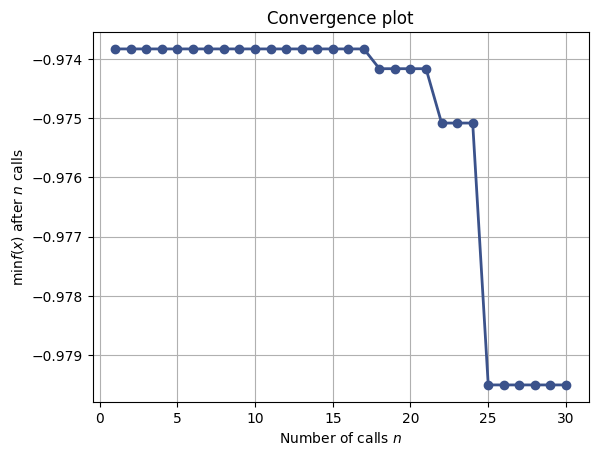

In [67]:
plot_convergence(gp_)

In [68]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']

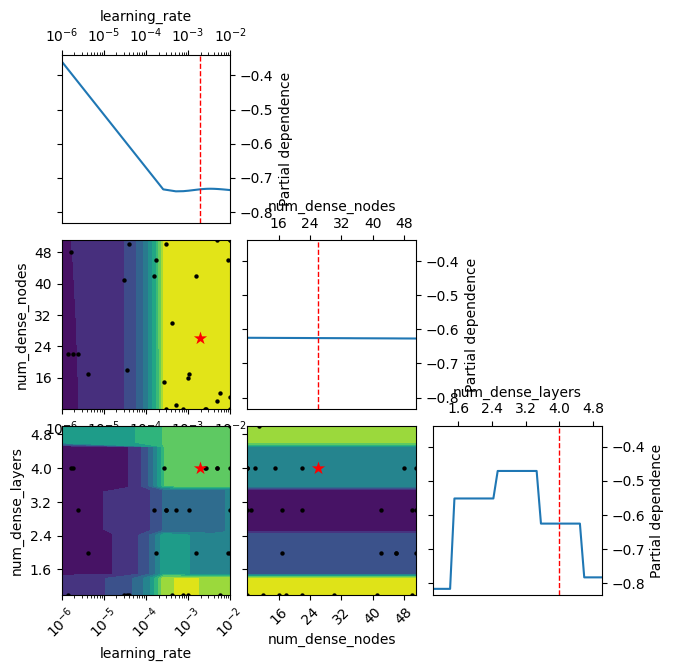

<Figure size 1500x2000 with 0 Axes>

In [70]:
plot_objective(result=gp_, plot_dims=dim_names)
plt.figure(figsize=(15, 20))
plt.show()

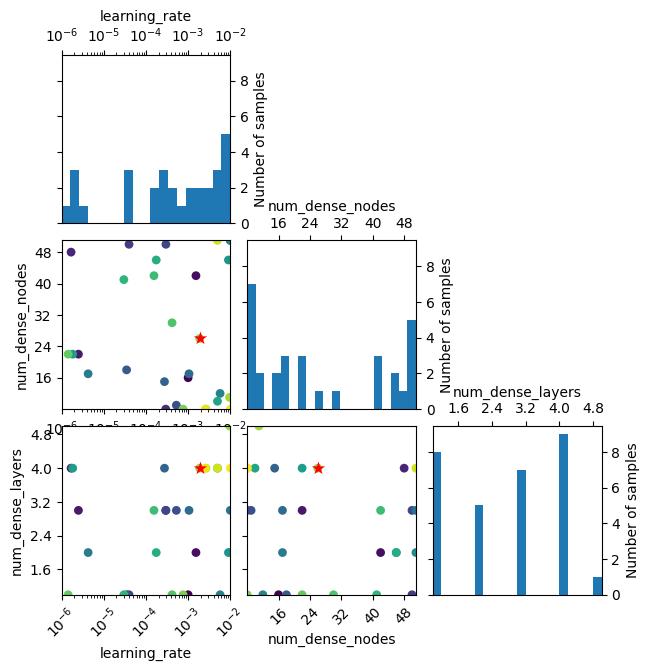

In [71]:
plot_evaluations(result=gp_, plot_dims=dim_names)
plt.show()